https://thispersondoesnotexist.com/

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras import models, layers
from tensorflow.keras.layers import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
if not os.path.exists('data/gan_images'):
    os.mkdir('data/gan_images')

In [3]:
# 생성자 모델
generator = models.Sequential()
generator.add(layers.Dense(7*7*128, input_dim=100,
                    activation=layers.LeakyReLU(0.2))) # 7*7*128*100 + 6272
generator.add(layers.BatchNormalization())
generator.add(layers.Reshape((7, 7, 128))) # 채널이 128개
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(64, kernel_size=5, padding='same'))
generator.add(layers.BatchNormalization())
generator.add(layers.Activation(LeakyReLU(0.2)))
generator.add(layers.UpSampling2D())
generator.add(layers.Conv2D(1, kernel_size=5, padding='same', activation='tanh'))
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 64)        0

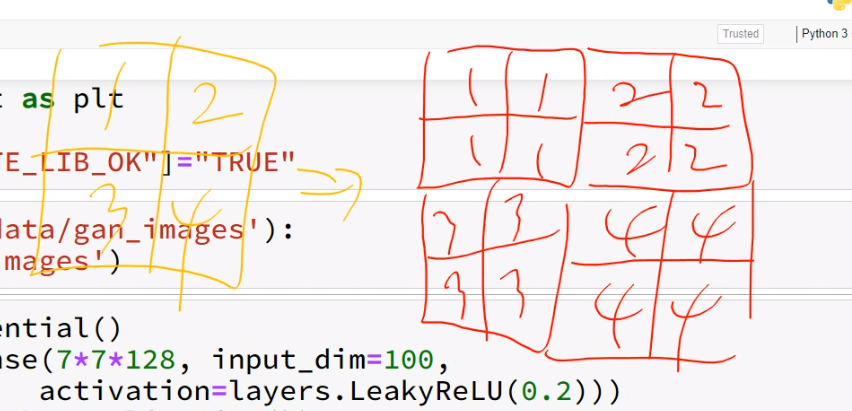

upsampling

In [4]:
# 판별자 모델
discriminator = models.Sequential()
discriminator.add(layers.Conv2D(64, kernel_size=5, strides=2,
                               input_shape=(28, 28, 1), padding='same'))
discriminator.add(layers.Activation(LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Conv2D(128, kernel_size=5, strides=2,
                                padding='same'))
discriminator.add(layers.Activation(LeakyReLU(0.2)))
discriminator.add(layers.Dropout(0.3))
discriminator.add(layers.Flatten()) # 1차원 dense 집어 넣으려고
discriminator.add(layers.Dense(1, activation='sigmoid'))
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

stride size를 몇으로 잡는지에 따라서 사이즈가 달라진다.

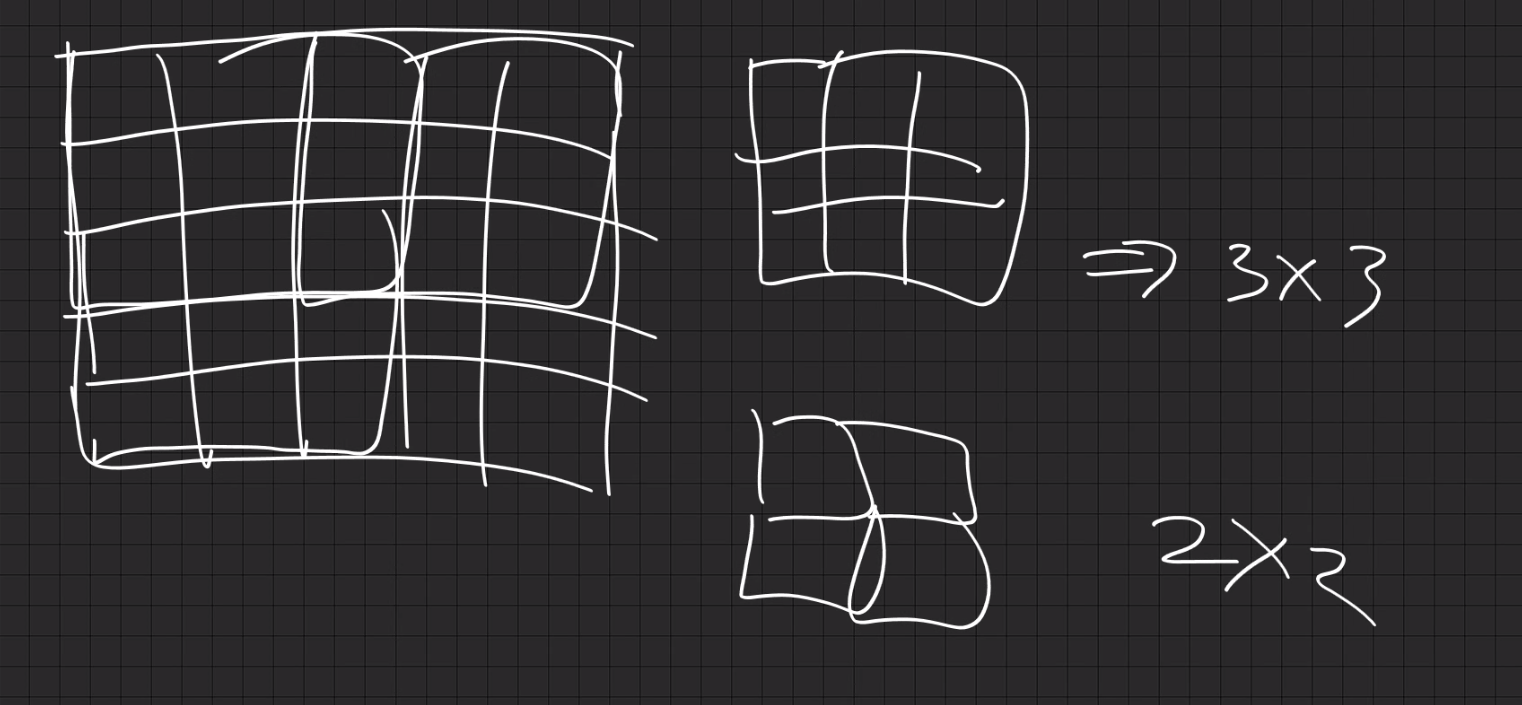

In [5]:
discriminator.compile(loss='binary_crossentropy', optimizer='adam')
discriminator.trainable = False

In [6]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
activation_2 (Activation)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [7]:
ginput = layers.Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = models.Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [8]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)
    X_train = (X_train - 127.5) / 127.5
    
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, 'd_loss:%.4f' % d_loss,
             'g_loss:%.4f' % g_loss)
        
        if i % saving_interval == 0:
              #r, c = 5, 5
              noise = np.random.normal(0, 1, (25, 100))
              gen_imgs = generator.predict(noise)

              # Rescale images 0 - 1
              gen_imgs = 0.5 * gen_imgs + 0.5

              fig, axs = plt.subplots(5, 5)
              count = 0
              for j in range(5):
                  for k in range(5):
                      axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                      axs[j, k].axis('off')
                      count += 1
              fig.savefig("data/gan_images/gan_mnist_%d.png" % i)

In [9]:
def gan_train(epoch, batch_size, saving_interval):
    (X_train, _), (_, _) = mnist.load_data()
    X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(float)

     # 127.5를 뺀 후 127.5로 나누어서 픽셀 값이 -1~1 사이의 값으로 바뀐다.
     # 그 이유는 생성자가 마지막에 tanh으로 통과시키기 때문에 -1~1 사이의 값이
     # 나온다.
    X_trian = (X_train - 127.5) / 127.5
    true = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))
    
    for i in range(epoch):
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        # 전체 개수에서 batch_size 만큼.. 뽑는다.
        imgs = X_train[idx]
        d_loss_real = discriminator.train_on_batch(imgs, true)
        #  네트워크를 수정하면 안되니깐 생성자만 수정 가능
        # discriminator 학습.. train_on_batch가 real imgs
        # 입력값 타겟값을 줘서 학습시킨다.
        
        noise = np.random.normal(0, 1, (batch_size, 100))
        gen_imgs = generator.predict(noise)
        # gen_imgs 결과가 나옴 
        d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
        
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        g_loss = gan.train_on_batch(noise, true)
        
        print('epoch:%d' % i, ' d_loss:%.4f' % d_loss, ' g_loss:%.4f' % g_loss)
        
      # 중간 과정을 이미지로 저장하는 부분입니다. 정해진 인터벌만큼 학습되면
        # 그때 만든 이미지를 gan_images 폴더에 저장하라는 의미입니다.
        # 이 코드는 이 장의 주된 목표와는 관계가 없어서 소스 코드만 소개합니다.
        if i % saving_interval == 0:
            # r, c = 5, 5
            noise = np.random.normal(0, 1, (25, 100))
            gen_imgs = generator.predict(noise)

            # Rescale images 0 - 1
            gen_imgs = 0.5 * gen_imgs + 0.5

            fig, axs = plt.subplots(5, 5)
            count = 0
            for j in range(5):
                for k in range(5):
                    axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap='gray')
                    axs[j, k].axis('off')
                    count += 1
            fig.savefig("data/gan_images/gan_mnist_%d.png" % i)


epoch:0  d_loss:0.7203  g_loss:0.5611
epoch:1  d_loss:0.3910  g_loss:0.3609
epoch:2  d_loss:0.4338  g_loss:0.2060
epoch:3  d_loss:0.5138  g_loss:0.1202
epoch:4  d_loss:0.5732  g_loss:0.0977
epoch:5  d_loss:0.6112  g_loss:0.0938
epoch:6  d_loss:0.6215  g_loss:0.1320
epoch:7  d_loss:0.5910  g_loss:0.1966
epoch:8  d_loss:0.5295  g_loss:0.3088
epoch:9  d_loss:0.4599  g_loss:0.4956
epoch:10  d_loss:0.4028  g_loss:0.6811
epoch:11  d_loss:0.3415  g_loss:0.8775
epoch:12  d_loss:0.3071  g_loss:1.0557
epoch:13  d_loss:0.2820  g_loss:1.2402
epoch:14  d_loss:0.2572  g_loss:1.3859
epoch:15  d_loss:0.2533  g_loss:1.4690
epoch:16  d_loss:0.4149  g_loss:1.2918
epoch:17  d_loss:0.2656  g_loss:1.1447
epoch:18  d_loss:0.3583  g_loss:0.9064
epoch:19  d_loss:0.3877  g_loss:0.7734
epoch:20  d_loss:0.4019  g_loss:0.6840
epoch:21  d_loss:0.4607  g_loss:0.6651
epoch:22  d_loss:0.4394  g_loss:0.6437
epoch:23  d_loss:0.4130  g_loss:0.6962
epoch:24  d_loss:0.3607  g_loss:0.7539
epoch:25  d_loss:0.3557  g_loss:0.8

epoch:208  d_loss:0.0003  g_loss:7.0614
epoch:209  d_loss:0.0004  g_loss:7.2341
epoch:210  d_loss:0.0003  g_loss:7.1591
epoch:211  d_loss:0.0003  g_loss:7.2268
epoch:212  d_loss:0.0004  g_loss:7.3178
epoch:213  d_loss:0.0003  g_loss:7.1529
epoch:214  d_loss:0.0003  g_loss:7.1710
epoch:215  d_loss:0.0003  g_loss:7.1919
epoch:216  d_loss:0.0003  g_loss:7.3640
epoch:217  d_loss:0.0003  g_loss:7.3816
epoch:218  d_loss:0.0003  g_loss:7.2890
epoch:219  d_loss:0.0003  g_loss:7.3229
epoch:220  d_loss:0.0003  g_loss:7.2533
epoch:221  d_loss:0.0003  g_loss:7.4214
epoch:222  d_loss:0.0003  g_loss:7.3923
epoch:223  d_loss:0.0003  g_loss:7.5496
epoch:224  d_loss:0.0003  g_loss:7.3109
epoch:225  d_loss:0.0003  g_loss:7.4603
epoch:226  d_loss:0.0003  g_loss:7.5168
epoch:227  d_loss:0.0003  g_loss:7.4821
epoch:228  d_loss:0.0003  g_loss:7.4581
epoch:229  d_loss:0.0003  g_loss:7.3454
epoch:230  d_loss:0.0003  g_loss:7.3672
epoch:231  d_loss:0.0003  g_loss:7.3711
epoch:232  d_loss:0.0002  g_loss:7.3880


epoch:413  d_loss:0.0001  g_loss:8.7412
epoch:414  d_loss:0.0001  g_loss:8.9210
epoch:415  d_loss:0.0001  g_loss:8.7315
epoch:416  d_loss:0.0001  g_loss:8.8600
epoch:417  d_loss:0.0001  g_loss:8.8255
epoch:418  d_loss:0.0001  g_loss:8.9465
epoch:419  d_loss:0.0001  g_loss:9.0038
epoch:420  d_loss:0.0001  g_loss:9.0347
epoch:421  d_loss:0.0001  g_loss:8.8976
epoch:422  d_loss:0.0001  g_loss:8.9605
epoch:423  d_loss:0.0001  g_loss:9.0882
epoch:424  d_loss:0.0001  g_loss:8.9008
epoch:425  d_loss:0.0001  g_loss:8.8726
epoch:426  d_loss:0.0001  g_loss:9.1495
epoch:427  d_loss:0.0001  g_loss:8.9866
epoch:428  d_loss:0.0001  g_loss:8.9224
epoch:429  d_loss:0.0001  g_loss:9.0406
epoch:430  d_loss:0.0001  g_loss:9.0270
epoch:431  d_loss:0.0001  g_loss:9.0073
epoch:432  d_loss:0.0001  g_loss:8.9826
epoch:433  d_loss:0.0001  g_loss:8.9737
epoch:434  d_loss:0.0001  g_loss:9.0346
epoch:435  d_loss:0.0001  g_loss:9.0569
epoch:436  d_loss:0.0001  g_loss:9.1585
epoch:437  d_loss:0.0001  g_loss:9.0347


epoch:618  d_loss:0.0000  g_loss:10.1354
epoch:619  d_loss:0.0000  g_loss:10.1689
epoch:620  d_loss:0.0000  g_loss:10.1611
epoch:621  d_loss:0.0000  g_loss:10.1400
epoch:622  d_loss:0.0000  g_loss:10.0014
epoch:623  d_loss:0.0000  g_loss:10.1535
epoch:624  d_loss:0.0000  g_loss:10.0677
epoch:625  d_loss:0.0000  g_loss:10.0975
epoch:626  d_loss:0.0000  g_loss:10.0684
epoch:627  d_loss:0.0000  g_loss:10.1475
epoch:628  d_loss:0.0000  g_loss:10.1773
epoch:629  d_loss:0.0000  g_loss:10.1227
epoch:630  d_loss:0.0000  g_loss:10.0904
epoch:631  d_loss:0.0000  g_loss:10.2581
epoch:632  d_loss:0.0000  g_loss:10.1270
epoch:633  d_loss:0.0000  g_loss:10.1429
epoch:634  d_loss:0.0000  g_loss:10.1229
epoch:635  d_loss:0.0000  g_loss:10.0568
epoch:636  d_loss:0.0000  g_loss:10.1837
epoch:637  d_loss:0.0000  g_loss:10.2212
epoch:638  d_loss:0.0000  g_loss:10.2190
epoch:639  d_loss:0.0000  g_loss:10.0540
epoch:640  d_loss:0.0000  g_loss:10.3034
epoch:641  d_loss:0.0000  g_loss:10.1687
epoch:642  d_los

epoch:818  d_loss:0.0000  g_loss:10.8494
epoch:819  d_loss:0.0000  g_loss:10.8064
epoch:820  d_loss:0.0000  g_loss:10.8929
epoch:821  d_loss:0.0000  g_loss:10.8601
epoch:822  d_loss:0.0000  g_loss:10.7854
epoch:823  d_loss:0.0000  g_loss:10.9363
epoch:824  d_loss:0.0000  g_loss:10.8984
epoch:825  d_loss:0.0000  g_loss:10.8509
epoch:826  d_loss:0.0000  g_loss:10.8656
epoch:827  d_loss:0.0000  g_loss:10.9471
epoch:828  d_loss:0.0000  g_loss:10.7197
epoch:829  d_loss:0.0000  g_loss:10.6368
epoch:830  d_loss:0.0000  g_loss:10.9543
epoch:831  d_loss:0.0000  g_loss:10.9482
epoch:832  d_loss:0.0000  g_loss:10.9947
epoch:833  d_loss:0.0000  g_loss:10.8164
epoch:834  d_loss:0.0000  g_loss:11.1018
epoch:835  d_loss:0.0000  g_loss:10.8981
epoch:836  d_loss:0.0000  g_loss:10.9193
epoch:837  d_loss:0.0000  g_loss:10.8739
epoch:838  d_loss:0.0000  g_loss:10.9100
epoch:839  d_loss:0.0000  g_loss:10.8642
epoch:840  d_loss:0.0000  g_loss:10.9000
epoch:841  d_loss:0.0000  g_loss:11.0366
epoch:842  d_los

epoch:1018  d_loss:0.0000  g_loss:11.4266
epoch:1019  d_loss:0.0000  g_loss:11.3703
epoch:1020  d_loss:0.0000  g_loss:11.3017
epoch:1021  d_loss:0.0000  g_loss:11.5164
epoch:1022  d_loss:0.0000  g_loss:11.4909
epoch:1023  d_loss:0.0000  g_loss:11.4359
epoch:1024  d_loss:0.0000  g_loss:11.4764
epoch:1025  d_loss:0.0000  g_loss:11.5258
epoch:1026  d_loss:0.0000  g_loss:11.4147
epoch:1027  d_loss:0.0000  g_loss:11.4416
epoch:1028  d_loss:0.0000  g_loss:11.2650
epoch:1029  d_loss:0.0000  g_loss:11.5318
epoch:1030  d_loss:0.0000  g_loss:11.4287
epoch:1031  d_loss:0.0000  g_loss:11.4732
epoch:1032  d_loss:0.0000  g_loss:11.4552
epoch:1033  d_loss:0.0000  g_loss:11.4908
epoch:1034  d_loss:0.0000  g_loss:11.4396
epoch:1035  d_loss:0.0000  g_loss:11.5156
epoch:1036  d_loss:0.0000  g_loss:11.5553
epoch:1037  d_loss:0.0000  g_loss:11.4169
epoch:1038  d_loss:0.0000  g_loss:11.4865
epoch:1039  d_loss:0.0000  g_loss:11.6508
epoch:1040  d_loss:0.0000  g_loss:11.6683
epoch:1041  d_loss:0.0000  g_loss:

epoch:1214  d_loss:0.0000  g_loss:11.9614
epoch:1215  d_loss:0.0000  g_loss:11.9797
epoch:1216  d_loss:0.0000  g_loss:11.8046
epoch:1217  d_loss:0.0000  g_loss:11.8667
epoch:1218  d_loss:0.0000  g_loss:11.7443
epoch:1219  d_loss:0.0000  g_loss:12.0199
epoch:1220  d_loss:0.0000  g_loss:11.9565
epoch:1221  d_loss:0.0000  g_loss:11.8791
epoch:1222  d_loss:0.0000  g_loss:11.9259
epoch:1223  d_loss:0.0000  g_loss:11.8289
epoch:1224  d_loss:0.0000  g_loss:12.0710
epoch:1225  d_loss:0.0000  g_loss:11.9142
epoch:1226  d_loss:0.0000  g_loss:11.8218
epoch:1227  d_loss:0.0000  g_loss:11.9665
epoch:1228  d_loss:0.0000  g_loss:11.8516
epoch:1229  d_loss:0.0000  g_loss:11.8149
epoch:1230  d_loss:0.0000  g_loss:11.8772
epoch:1231  d_loss:0.0000  g_loss:11.9730
epoch:1232  d_loss:0.0000  g_loss:11.8738
epoch:1233  d_loss:0.0000  g_loss:12.0159
epoch:1234  d_loss:0.0000  g_loss:11.8917
epoch:1235  d_loss:0.0000  g_loss:11.9947
epoch:1236  d_loss:0.0000  g_loss:11.9821
epoch:1237  d_loss:0.0000  g_loss:

epoch:1410  d_loss:0.0000  g_loss:12.4586
epoch:1411  d_loss:0.0000  g_loss:12.1832
epoch:1412  d_loss:0.0000  g_loss:12.1946
epoch:1413  d_loss:0.0000  g_loss:12.4153
epoch:1414  d_loss:0.0000  g_loss:12.2591
epoch:1415  d_loss:0.0000  g_loss:12.3169
epoch:1416  d_loss:0.0000  g_loss:12.3160
epoch:1417  d_loss:0.0000  g_loss:12.3289
epoch:1418  d_loss:0.0000  g_loss:12.2345
epoch:1419  d_loss:0.0000  g_loss:12.4360
epoch:1420  d_loss:0.0000  g_loss:12.2919
epoch:1421  d_loss:0.0000  g_loss:12.3426
epoch:1422  d_loss:0.0000  g_loss:12.2982
epoch:1423  d_loss:0.0000  g_loss:12.5020
epoch:1424  d_loss:0.0000  g_loss:12.3948
epoch:1425  d_loss:0.0000  g_loss:12.3383
epoch:1426  d_loss:0.0000  g_loss:12.4444
epoch:1427  d_loss:0.0000  g_loss:12.3828
epoch:1428  d_loss:0.0000  g_loss:12.4163
epoch:1429  d_loss:0.0000  g_loss:12.4594
epoch:1430  d_loss:0.0000  g_loss:12.3362
epoch:1431  d_loss:0.0000  g_loss:12.3690
epoch:1432  d_loss:0.0000  g_loss:12.3195
epoch:1433  d_loss:0.0000  g_loss:

epoch:1606  d_loss:0.0000  g_loss:12.8153
epoch:1607  d_loss:0.0000  g_loss:12.7962
epoch:1608  d_loss:0.0000  g_loss:12.8587
epoch:1609  d_loss:0.0000  g_loss:12.7629
epoch:1610  d_loss:0.0000  g_loss:12.7162
epoch:1611  d_loss:0.0000  g_loss:12.5429
epoch:1612  d_loss:0.0000  g_loss:12.5525
epoch:1613  d_loss:0.0000  g_loss:12.6237
epoch:1614  d_loss:0.0000  g_loss:12.7445
epoch:1615  d_loss:0.0000  g_loss:12.7007
epoch:1616  d_loss:0.0000  g_loss:12.5405
epoch:1617  d_loss:0.0000  g_loss:12.7176
epoch:1618  d_loss:0.0000  g_loss:12.5629
epoch:1619  d_loss:0.0000  g_loss:12.7508
epoch:1620  d_loss:0.0000  g_loss:12.7705
epoch:1621  d_loss:0.0000  g_loss:12.7301
epoch:1622  d_loss:0.0000  g_loss:12.7263
epoch:1623  d_loss:0.0000  g_loss:12.5757
epoch:1624  d_loss:0.0000  g_loss:12.8430
epoch:1625  d_loss:0.0000  g_loss:12.8476
epoch:1626  d_loss:0.0000  g_loss:12.6290
epoch:1627  d_loss:0.0000  g_loss:12.6070
epoch:1628  d_loss:0.0000  g_loss:12.7480
epoch:1629  d_loss:0.0000  g_loss:

epoch:1802  d_loss:0.0000  g_loss:12.9716
epoch:1803  d_loss:0.0000  g_loss:13.0211
epoch:1804  d_loss:0.0000  g_loss:13.0640
epoch:1805  d_loss:0.0000  g_loss:13.2206
epoch:1806  d_loss:0.0000  g_loss:12.7812
epoch:1807  d_loss:0.0000  g_loss:13.0746
epoch:1808  d_loss:0.0000  g_loss:13.0197
epoch:1809  d_loss:0.0000  g_loss:12.8924
epoch:1810  d_loss:0.0000  g_loss:13.0523
epoch:1811  d_loss:0.0000  g_loss:13.0955
epoch:1812  d_loss:0.0000  g_loss:13.0440
epoch:1813  d_loss:0.0000  g_loss:12.9889
epoch:1814  d_loss:0.0000  g_loss:13.1155
epoch:1815  d_loss:0.0000  g_loss:12.9736
epoch:1816  d_loss:0.0000  g_loss:13.1819
epoch:1817  d_loss:0.0000  g_loss:12.9876
epoch:1818  d_loss:0.0000  g_loss:13.0132
epoch:1819  d_loss:0.0000  g_loss:13.0285
epoch:1820  d_loss:0.0000  g_loss:13.2216
epoch:1821  d_loss:0.0000  g_loss:12.9846
epoch:1822  d_loss:0.0000  g_loss:12.9967
epoch:1823  d_loss:0.0000  g_loss:13.0877
epoch:1824  d_loss:0.0000  g_loss:12.9425
epoch:1825  d_loss:0.0000  g_loss:

epoch:1998  d_loss:0.0000  g_loss:13.1487
epoch:1999  d_loss:0.0000  g_loss:13.2526
epoch:2000  d_loss:0.0000  g_loss:13.3609


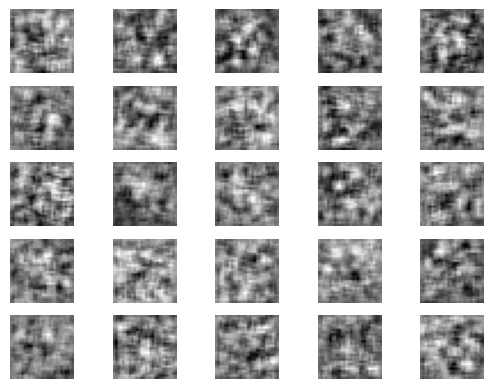

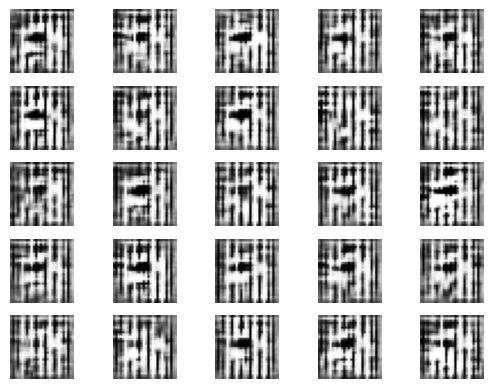

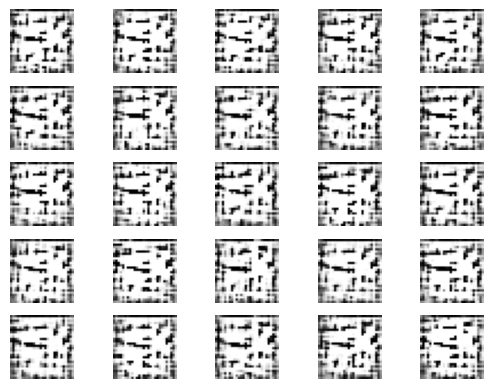

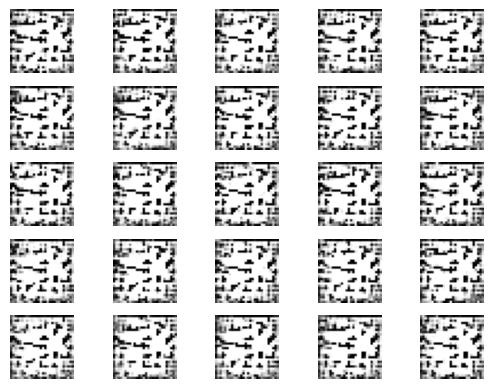

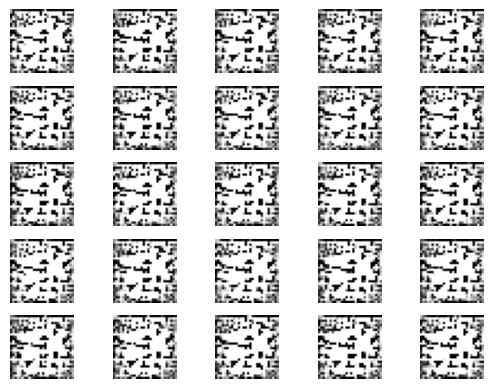

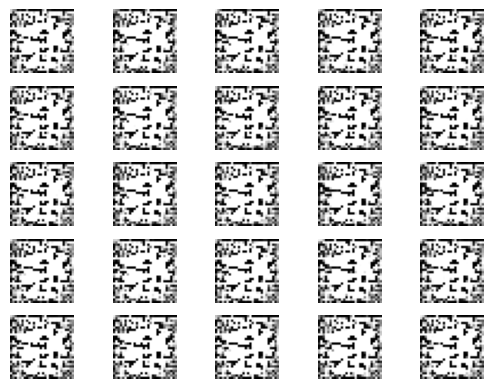

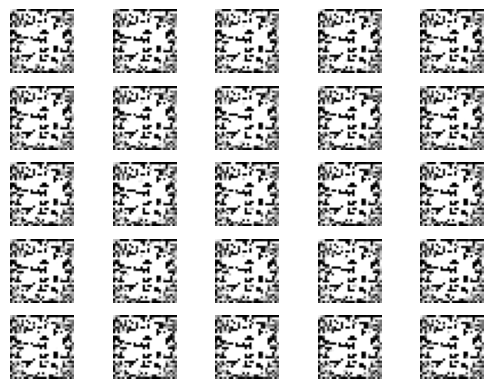

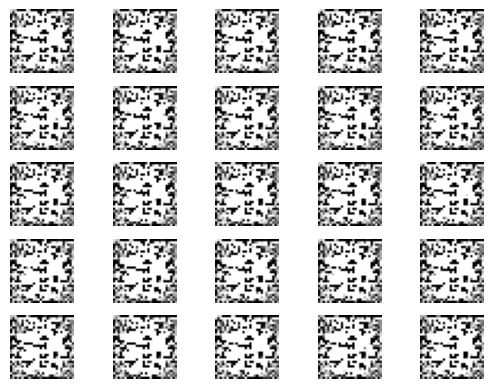

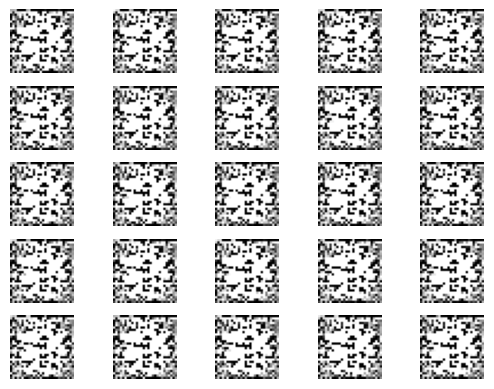

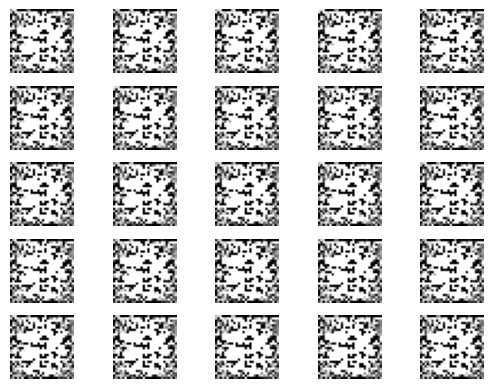

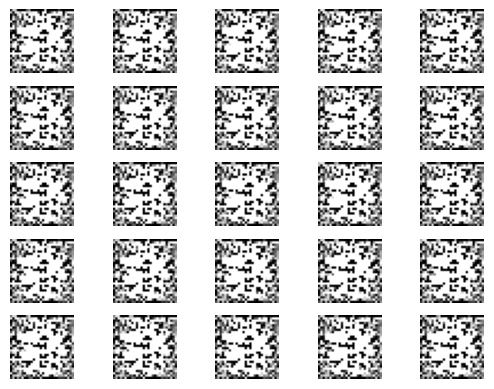

In [10]:
gan_train(2001, 32, 200)